# Dependence of Algorithms on Ansatz Depth

The first component of any quantum variational algorithm is the __ansatz__. Ansatz is the composition of a __reference circuit__ and a __variational form__. 
* _Reference circuit_ is the quantum circuit that prepares the reference state, a non-parametric state, that serves as the initial state for the quantum variational algorithm.
* _Variational circuit_ is a parametric circuit, consisting of parametric rotation and entangling gates.
Together, they form the ansatz.

The importance of the ansatz is better explained with an abstract example. Consider a Hamiltonian $H_p$ for a problem $P$ such that the ground state and the ground state energy of the Hamiltonian can be used to find the optimal solution to $P$. Additionally, let the Hamiltonian be an $n$ qubit Hamiltonian. Then, we know that the ground state of $H_p$ is some $n$-qubit state $|\psi_g\rangle$. The goal of the variational algorithm is to construct the ground state $|\psi_g\rangle$. Since $|\psi\rangle$ is some arbitrary $n$ qubit state (whose structure we have no idea about), the number of gates required can be as large as $O(2^n)$. This means that a perfect ansatz will involve exponentially many parameters. In that case, one can simply simulate the Hamiltonian classically without the need for quantum resources. So, it is important that the ansatz is not exponentially large. In fact, we would like an ansatz that contains polynomially many gates. But this reduces the __expressivity__ of the ansatz, or in other words, there is a reduction in the number of states that can be prepared using the ansatz. So, there is a tradeoff between the number of parameters and the expressivity of an ansatz. So, choosing the good (whatever that should mean) ansatz is hugely important.

One approach towards a good ansatz is to use some properties of the problem Hamiltonian $H_p$ to get some insight on the structure of the ground state $|\psi_g\rangle$. This could allow us to construct a small enough ansatz that will be able to prepare the ground state. For instance, if for some problem Hamiltonian, we know that the ground state takes the form $\ket{\phi(\Theta)} = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1} e^{-i\theta_j}\ket{j}$, then it is possible to construct a polynomial-sized ansatz that explores only the states of the form $\ket{\phi(\Theta)}$. Such ansatzes are called _problem-dependent ansatz_.

Another approach, one used in QAOA-style algorithms, is to borrow the structure from quantum annealing techniques that solve the problem.

Our goal in this notebook is to investigate how the depth of the ansatz affects the performance of the algorithms. For this comparison, we use three different metrics as a proxy for the depth of an ansatz.

1. __Number of repetitions of an ansatz sub-circuit__.

Most of the ansatz is prepared by repeating an ansatz sub-circuit multiple times. For instance, the ansatz for VQE is prepared by repeating alternating layers of parametric rotations and entangling gates. Similarly, for QAOA and QAOA-style algorithms like ADAPT-QAOA and DC-QAOA, the ansatz consists of alternating circuits corresponding to the problem and the mixer Hamiltonians. In this case, the metric we use to compare algorithms is the number of repetitions of these sub-circuits, which we call _Max-Repetitions_.

2. __The depth of the ansatz circuit__.

While an equal number of repetitions naively looks like a good metric, two different algorithms that use subcircuits of different size would perform differently. The algorithm that uses the larger subcircuit gains an advantage over the other since larger circuits have more expresivity thatn smaller circuits. An alternate measure that can be consider is the _depth of the ansatz_. Two circuits of similar depth more or less take the take time to execute. So, we consider the power of algorithms when their ansatzes are of the same depth.

3. __Number of parameters__.

Similar to the depth of the ansatz being a good measure for the time on a quantum system, the number of parameters give a good measure of the time required in the classical system. For instance, a cost function with small number of parameters is relatively easy to optimize over than a cost function with large number of parameters, for any classical optimizer. So, finally, we consider the performance of algorithms when their ansatzes have same number of parameters.

### 3. Number of Parameters of the Ansatz Circuits

One of the most relevant parameters associated with the expressivity of an ansatz is the __number of parameters__ of the ansatz. Of course, this is with the assumption that the ansatz contains a fair mixture of gates (An ansatz with RX, RY, and RZ gates can reach way more states than an ansatz with just RZ gates, even if the number of parameters is the same for both).

In this notebook, we will study the comparative performance of variational algorithms when the number of parameters is fixed.

### Importing required functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA
from src.vqe import VQE
from src.dcqaoa import DCQAOA

#### Graph Generation and Brute Force Optimization

In [4]:
num_instances = 10
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(6, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [5]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

Unlike the depth of an ansatz, computing the number of parameters in an ansatz for any of the variational algorithms we consider is very straightforward. For any algorithm apart from VQE, if the ansatz of an algorithm contains $k$ many parameters when the number of repetitions is $1$, then the ansatz for that algorithm will contain $k\cdot l$ many parameters when the number of repetitions is $l$. As for VQE, when we consider a two-local ansatz with $RX$ gates for rotation blocks and $CZ$ gates for entanglement, an additional layer of rotational gates is added after the last layer of repetition of the ansatz sub-circuit. So, if the number of parameters for a single repetition ansatz is $k+k$, then the number of parameters for an $l$ layer ansatz comes out to be $(l+1)\cdot k$.

So, to compute the number of parameters for different numbers of repetitions, let us first figure out the number of parameters in the ansatz for a single layer of repetition for each of the algorithms under consideration.

In [6]:
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager

backend = AerSimulator()
pm = generate_preset_pass_manager(backend = backend, optimization_level = 3)

max_num_layers = 10

In [7]:
vqe_ansatz = TwoLocal(
    graph_hamiltonians[0].num_qubits,
    rotation_blocks = ['rx'],
    entanglement_blocks = ['cz'],
    entanglement = 'full',
    reps = 1
)
vqe_ansatz = pm.run(vqe_ansatz)
vqe_n_params = vqe_ansatz.num_parameters

print(f"The number of parmeters in the ansatz for VQE with a single layer of repetition is {vqe_n_params}.")

The number of parmeters in the ansatz for VQE with a single layer of repetition is 12.


We obtained that the number of parameters for the VQE ansatz with a single layer of repetition is $2k = 12$.

Next, for QAOA, the number of parameters in the ansatz with a single layer of repetition is $2$ as can be seen below.

In [8]:
qaoa = QAOA(graph_hamiltonians[0], num_layers = 1)
qaoa_ansatz = qaoa.prepare_ansatz()
qaoa_ansatz = pm.run(qaoa_ansatz)
qaoa_n_params = qaoa_ansatz.num_parameters
print(f"The number of parmeters in the ansatz for QAOA with a single layer of repetition is {qaoa_n_params}.")

The number of parmeters in the ansatz for QAOA with a single layer of repetition is 2.


Similarly, the number of parameters in the ansatz in DCQAOA with a single layer of repetition is $3$.

In [9]:
dcqaoa = DCQAOA(graph_hamiltonians[0], num_layers = 1, cd_hamiltonian_type = ['XY', 'YX'])
dcqaoa_ansatz = dcqaoa.prepare_ansatz()
dcqaoa_ansatz = pm.run(dcqaoa_ansatz)
dcqaoa_n_params = dcqaoa_ansatz.num_parameters
print(f"The number of parmeters in the ansatz for DCQAOA with a single layer of repetition is {dcqaoa_n_params}.")

The number of parmeters in the ansatz for DCQAOA with a single layer of repetition is 3.


Now, for ADAPT-QAOA, the ansatz is constructed on the go when the optimization is being performed. However, the number of parameters for each layer of repetition is $2$, since in each layer of repetition, $1$ parameter is associated with the circuit corresponding to the problem Hamiltonian and $1$ parameter is associated with the circuit corresponding to the mixer Hamiltonian. This is oblivious to the mixer pool type, as the mixer pool type only determines the number of candidate mixer Hamiltonians for each layer, and only a single mixer Hamiltonian is chosen for each layer. So, the number of parameters associated with the mixer Hamiltonian circuit for each layer of repetition remains $1$ in both the mixer pool types.

In [10]:
aqaoa_single_n_params = 2
aqaoa_double_n_params = 2

In [11]:
k_vqe = vqe_n_params/2
vqe_params = [(reps+1)*k_vqe for reps in range(11)]
qaoa_params = [reps*qaoa_n_params for reps in range(11)]
aqaoa_single_params = [reps*aqaoa_single_n_params for reps in range(11)]
aqaoa_double_params = [reps*aqaoa_double_n_params for reps in range(11)]
dcqaoa_params = [reps*dcqaoa_n_params for reps in range(11)]

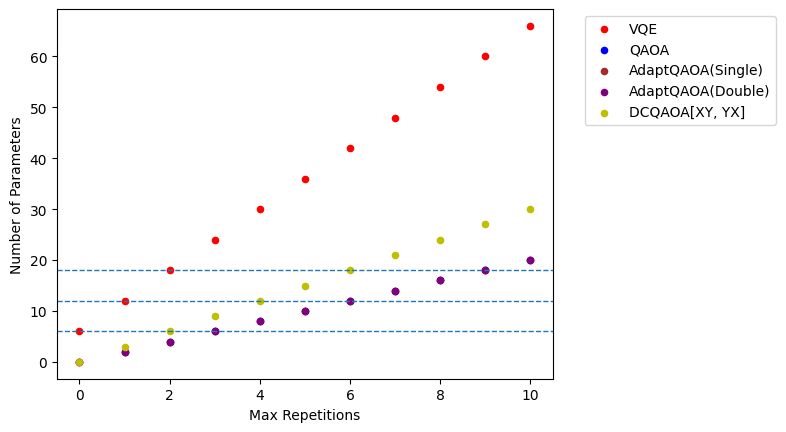

In [12]:
plt.scatter(range(11), vqe_params, color='r', label='VQE', s=20)
plt.scatter(range(11), qaoa_params, color='b', label='QAOA', s=20)
plt.scatter(range(11), aqaoa_single_params, color='brown', label='AdaptQAOA(Single)', s=20)
plt.scatter(range(11), aqaoa_double_params, color='purple', label='AdaptQAOA(Double)', s=20)
plt.scatter(range(11), dcqaoa_params, color='y', label='DCQAOA[XY, YX]', s=20)

plt.axhline(y=6, linestyle='--', linewidth=1)
plt.axhline(y=12, linestyle='--', linewidth=1)
plt.axhline(y=18, linestyle='--', linewidth=1)

plt.xlabel("Max Repetitions")
plt.ylabel("Number of Parameters")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__Note:__ _Since the number of parameters for QAOA, ADAPT-QAOA(Single), and ADAPT-QAOA(Double) is equal for each layer of repetition, the scatter points corresponding to these algorithms overlap with each other in the provided scatter plot._

Clearly, for any fixed number of repetitions, the VQE ansatz has the largest number of parameters, at least $2$ times more than that of DCQAOA and at least $3$ times more than that of QAOA and ADAPT-QAOA.

For the comparison, we consider three different parameter budgets: $6$ parameters, $12$ parameters, and $18$ parameters. For VQE, the number of parameters, even for a single layer of repetition, is $12$. To limit the number of parameters to $6$, we use a two-local ansatz that consists of only the first rotation layer. So, the parameter budgets correspond to $0, 1$, and $2$ layers of repetition. For DCQAOA, the parameter budgets correspond to $2, 4$, and $6$ layers of repetition, and for QAOA and ADAPT-QAOA, they correspond to $3, 6$, and $9$ layers of repetition.

#### VQE

In [13]:
vqe_reps = [0, 1, 2]
avg_vqe_error = []

for reps in vqe_reps:
    print(f"Solving for reps {reps}...")
    vqe_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        vqe_ansatz = TwoLocal(
                    hamiltonian.num_qubits,
                    rotation_blocks = ['rx'],
                    entanglement_blocks = ['cz'],
                    entanglement = 'full',
                    reps = reps,
                )
        vqe = VQE(hamiltonian, ansatz = vqe_ansatz, optimizer_options = {'maxiter': 2000})
        vqe.run()
        vqe_rep_optimal_costs.append(vqe.optimal_value)
    vqe_error = [np.abs(b_opt - v_opt) for b_opt, v_opt in zip(brute_optimal_cost, vqe_rep_optimal_costs)]
    avg_vqe_error.append(sum(vqe_error)/num_instances)

Solving for reps 0...
Solving for reps 1...
Solving for reps 2...


#### QAOA

In [14]:
qaoa_reps = [3, 6, 9]
avg_qaoa_error = []

for reps in qaoa_reps:
    print(f"Solving for reps {reps}...")
    qaoa_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        qaoa = QAOA(hamiltonian, num_layers = reps, optimizer_options = {'maxiter': 2000})
        qaoa.run()
        qaoa_rep_optimal_costs.append(qaoa.optimal_value)
    qaoa_error = [np.abs(b_opt - q_opt) for b_opt, q_opt in zip(brute_optimal_cost, qaoa_rep_optimal_costs)]
    avg_qaoa_error.append(sum(qaoa_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
Solving for reps 9...


#### ADAPT-QAOA (Single)

In [15]:
aqaoa_single_reps = [3, 6, 9]
avg_aqaoa_single_error = []

for reps in aqaoa_single_reps:
    print(f"Solving for reps {reps}...")
    aqaoa_single_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        aqaoa_single = AdaptQAOA(hamiltonian, max_num_layers = reps, mixer_pool_type = 'single', optimizer_options = {'maxiter': 2000})
        aqaoa_single.run()
        aqaoa_single_rep_optimal_costs.append(aqaoa_single.optimal_value)
    aqaoa_single_error = [np.abs(b_opt - a_s_opt) for b_opt, a_s_opt in zip(brute_optimal_cost, aqaoa_single_rep_optimal_costs)]
    avg_aqaoa_single_error.append(sum(aqaoa_single_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
Solving for reps 9...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The

#### ADAPT-QAOA (Double)

In [16]:
aqaoa_double_reps = [3, 6, 9]
avg_aqaoa_double_error = []

for reps in aqaoa_double_reps:
    print(f"Solving for reps {reps}...")
    aqaoa_double_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        aqaoa_double = AdaptQAOA(hamiltonian, max_num_layers = reps, mixer_pool_type = 'double', optimizer_options = {'maxiter': 2000})
        aqaoa_double.run()
        aqaoa_double_rep_optimal_costs.append(aqaoa_double.optimal_value)
    aqaoa_double_error = [np.abs(b_opt - a_d_opt) for b_opt, a_d_opt in zip(brute_optimal_cost, aqaoa_double_rep_optimal_costs)]
    avg_aqaoa_double_error.append(sum(aqaoa_double_error)/num_instances)

Solving for reps 3...
Solving for reps 6...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
Solving for reps 9...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


#### DCQAOA \['XY', 'YX'\]

In [18]:
dcqaoa_reps = [2, 4, 6]
avg_dcqaoa_error = []

for reps in dcqaoa_reps:
    print(f"Solving for reps {reps}...")
    dcqaoa_rep_optimal_costs = []
    for hamiltonian in graph_hamiltonians:
        dcqaoa = DCQAOA(hamiltonian, num_layers = reps, cd_hamiltonian_type = ['XY', 'YX'], optimizer_options = {'maxiter': 2000})
        dcqaoa.run()
        dcqaoa_rep_optimal_costs.append(dcqaoa.optimal_value)
    dcqaoa_error = [np.abs(b_opt - q_opt) for b_opt, q_opt in zip(brute_optimal_cost, dcqaoa_rep_optimal_costs)]
    avg_dcqaoa_error.append(sum(dcqaoa_error)/num_instances)

Solving for reps 2...
Solving for reps 4...
Solving for reps 6...


#### Plotting the results

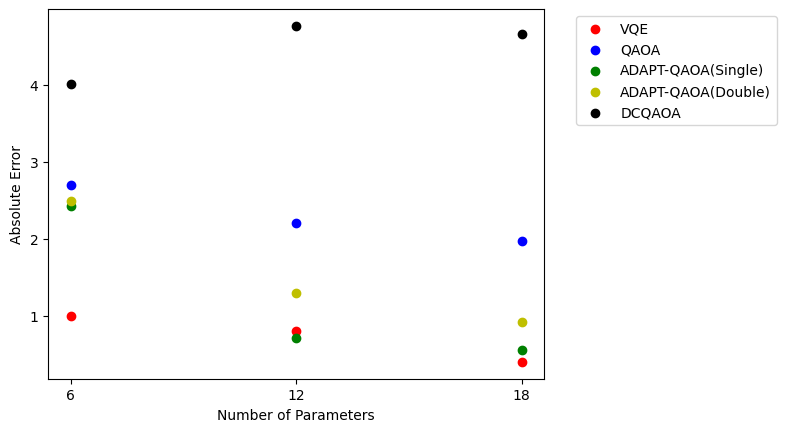

In [19]:
plt.scatter(range(3), avg_vqe_error, color = 'r', label = 'VQE')
plt.scatter(range(3), avg_qaoa_error, color = 'b', label = 'QAOA')
plt.scatter(range(3), avg_aqaoa_single_error, color = 'g', label = 'ADAPT-QAOA(Single)')
plt.scatter(range(3), avg_aqaoa_double_error, color = 'y', label = 'ADAPT-QAOA(Double)')
plt.scatter(range(3), avg_dcqaoa_error, color = 'k', label = 'DCQAOA')

plt.xticks([0, 1, 2], ['6', '12', '18'])
plt.xlabel('Number of Parameters')
plt.ylabel('Absolute Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can observe that when the number of parameters is $6$, VQE outperforms all the other algorithms. However, when the number of parameters in the ansatz is $12$ or $18$, the performances of VQE and ADAPT-QAOA with single mixer pool type are very similar and are better than the other algorithms. The performance of ADAPT-QAOA with the double mixer pool type closely follows that of VQE and ADAPT-QAOA with the single mixer pool type. In the experiments with fixed depth and fixed number of repetitions, VQE performed better than all algorithms. We hypothesized that this performance of VQE _could_ be due to the large number of parameters of VQE ansatzes. The experiments in this notebook indicate that the number of parameters is a __highly influential__ variable when it comes to expressivity of the ansatzes across the algorithms considered.


QAOA falls behind these three algorithms, although the error reduces as the number of parameters is increased. 

However, DCQAOA performs the worst of all algorithms, with no significant reduction in error even with an increase in the number of parameters. The performance of DCQAOA over all three settings of Ansatzes is very poor. It is surprising to see that DCQAOA performs worse than QAOA, even though the main idea of DCQAOA is a better approximation to quantum annealing than naive QAOA. Although we could possibly attribute this poor performance to the lack of $YZ$ and $ZY$ terms in the CD Hamiltonian, a deeper study is required to understand the cause of this poor performance across all settings.